# **<span style="color:White;">Scaling, Imputing and Heatmaps with Supervised Learning</span>**

## **Purpose of Notebook**
- Loading the cleaned Dataset
- Encoding and Scaling Functions 
- Imputing missing values 
- Sampling Techniques
- Correlation Heatmap

---

In [54]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from tabulate import tabulate
from prettytable import PrettyTable

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import (
    MinMaxScaler, StandardScaler, OrdinalEncoder, LabelEncoder
)

from sklearn.experimental import enable_iterative_imputer  # noqa
from sklearn.impute import SimpleImputer, KNNImputer, IterativeImputer

from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, confusion_matrix, mean_squared_error,
    silhouette_score
)
from sklearn.cluster import KMeans

from scipy import stats
from tabulate import tabulate
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder


### **Load Datasets**

In [55]:
# Display all columns of a pandas DataFrame when printed
pd.set_option('display.max_columns', None)

# US Dataset
US_data = pd.read_csv('/Users/mahnooriqbal/COMP702 Project/ML-AI-Risk-Analysis-AV-Data-/Datasets/US-cleaned_data.csv')
# UK Dataset
UK_data = pd.read_csv('/Users/mahnooriqbal/COMP702 Project/ML-AI-Risk-Analysis-AV-Data-/Datasets/UK-cleaned_data.csv')
UK_data = UK_data.drop(['latitude', 'longitude'], axis=1)

print("US Dataset Shape:", US_data.shape)
print("UK Dataset Shape:", UK_data.shape)

US Dataset Shape: (4372, 21)
UK Dataset Shape: (229782, 21)


**Split the columns**
- Vital to encode the catergorical and datetime columns seperately 
- Useful when trying different imputing methods
- Allows removal on id when needed

In [56]:
# Identify numerical and categorical columns
# treating speed limit as categorical numerical_columns 
categorical_columns = [
    'Make', 'Model', 'Model Year', 'ADS Equipped?',
    'Automation System Engaged?', 'City', 'State', 'Roadway Type', 'Roadway Surface',
    'Lighting', 'Crash With', 'Highest Injury Severity Alleged',
    'SV Pre-Crash Movement', 'SV Contact Area', 'Weather', 'Country','Posted Speed Limit (MPH)']

datetime_columns = ['Incident Date', 'Incident Time (24:00)']
indexing_columns = ['Report ID', 'Report Version']

### **Assessing Missing Values**

In [57]:
import numpy as np
from prettytable import PrettyTable

def display_missing_and_unknown_separate(dataset, dataset_name):
    # Columns that have missing or unknown values
    features_with_issues = [
        col for col in dataset.columns
        if dataset[col].isnull().sum() > 0 or
           dataset[col].astype(str).str.lower().str.contains('unknown').any()
    ]
    
    table = PrettyTable()
    table.field_names = ["Feature", "Percentage Missing", "Percentage 'Unknown'"]
    
    for col in features_with_issues:
        missing_pct = np.round(dataset[col].isnull().mean() * 100, 2)
        unknown_pct = np.round(dataset[col].astype(str).str.lower().str.contains('unknown').mean() * 100, 2)
        table.add_row([col, f"{missing_pct} %", f"{unknown_pct} %"])
    
    print(f"Missing and 'Unknown' Values in {dataset_name}:")
    print(table)

# Usage:
display_missing_and_unknown_separate(UK_data, "UK Dataset")
display_missing_and_unknown_separate(US_data, "US Dataset")


Missing and 'Unknown' Values in UK Dataset:
+----------+--------------------+----------------------+
| Feature  | Percentage Missing | Percentage 'Unknown' |
+----------+--------------------+----------------------+
| Lighting |       0.0 %        |        1.18 %        |
+----------+--------------------+----------------------+
Missing and 'Unknown' Values in US Dataset:
+---------------------------------+--------------------+----------------------+
|             Feature             | Percentage Missing | Percentage 'Unknown' |
+---------------------------------+--------------------+----------------------+
|               Make              |       0.0 %        |        0.02 %        |
|            Model Year           |       0.32 %       |        0.0 %         |
|    Automation System Engaged?   |       0.0 %        |        5.24 %        |
|          Incident Date          |       0.43 %       |        0.0 %         |
|      Incident Time (24:00)      |       4.6 %        |        0.0

In [58]:
# the speed limit is a huge chunk we can impute but we can drop the rest of the columns
US_data = US_data.dropna(subset=[col for col in US_data.columns if col != "Posted Speed Limit (MPH)"])
display_missing_and_unknown_separate(US_data, "US Dataset")

Missing and 'Unknown' Values in US Dataset:
+---------------------------------+--------------------+----------------------+
|             Feature             | Percentage Missing | Percentage 'Unknown' |
+---------------------------------+--------------------+----------------------+
|    Automation System Engaged?   |       0.0 %        |        2.31 %        |
|           Roadway Type          |       0.0 %        |       12.74 %        |
|         Roadway Surface         |       0.0 %        |       16.57 %        |
|     Posted Speed Limit (MPH)    |       7.93 %       |        0.0 %         |
|             Lighting            |       0.0 %        |       16.61 %        |
|            Crash With           |       0.0 %        |       19.81 %        |
| Highest Injury Severity Alleged |       0.0 %        |       49.84 %        |
|      SV Pre-Crash Movement      |       0.0 %        |       16.61 %        |
+---------------------------------+--------------------+--------------------

**Unknown vs Missing Data**
- if we drop the values recorded by the organisation as unknown we will get less than 1800 rows from the original 4000 size
- recording unknown and being missing is 2 different things
- imputing could add a lot of errors possibly 
- unknown can be handled by some models and is there a reason why it is even unknown in the first place? 
- if high accuracy imputing when we could use that method or treat unknown as it's own catergory

In [59]:

def replace_unknown_with_nan(df):
    """
    Replace all occurrences of 'Unknown' and 'Unknown, see Narrative' in the dataframe with NaN.
    
    Parameters:
    df (pd.DataFrame): Input dataframe
    
    Returns:
    pd.DataFrame: Dataframe with 'Unknown' values replaced by NaN
    """
    return df.replace(['Unknown', 'Unknown, see Narrative'], np.nan)

US_data = replace_unknown_with_nan(US_data)
display_missing_and_unknown_separate(US_data, "US Dataset")

Missing and 'Unknown' Values in US Dataset:
+---------------------------------+--------------------+----------------------+
|             Feature             | Percentage Missing | Percentage 'Unknown' |
+---------------------------------+--------------------+----------------------+
|    Automation System Engaged?   |       2.31 %       |        0.0 %         |
|           Roadway Type          |      12.74 %       |        0.0 %         |
|         Roadway Surface         |      16.57 %       |        0.0 %         |
|     Posted Speed Limit (MPH)    |       7.93 %       |        0.0 %         |
|             Lighting            |      15.94 %       |        0.67 %        |
|            Crash With           |      19.81 %       |        0.0 %         |
| Highest Injury Severity Alleged |      49.84 %       |        0.0 %         |
|      SV Pre-Crash Movement      |      16.61 %       |        0.0 %         |
+---------------------------------+--------------------+--------------------

the 0.67% is the dark unknowin lighting column

### **Imputing Missing Data**

**MSE for other methods**

**<span style="color:blue;">Mean/Mode Imputer</span>**
- **How it works:** Replaces missing values with the mean (for normally distributed data), or mode (for categorical variables).
- **Best for:** Small amounts of missing numerical data.
- **Limitations:** Can distort distributions and underestimate variance.

**<span style="color:blue;">Median Imputer</span>**
- **How it works:** Replaces missing values with the median (for normally distributed data), or mode (for categorical variables).
- **Best for:** Small amounts of missing numerical data.
- **Limitations:** Can distort distributions and underestimate variance.

**<span style="color:blue;">Random Imputer</span>**
- **How it works:** Replaces missing by random sampling from existing values  
- **Best for:** Maintaining original distribution with enough data  
- **Limitations:** Adds randomness; may create unrealistic combinations

**<span style="color:blue;">Last Occurance Carried Forward (LOCF) Imputer</span>**
- **How it works:** Replaces missing by random sampling from existing values  
- **Best for:** Maintaining original distribution with enough data  
- **Limitations:** Adds randomness; may create unrealistic combinations

In [60]:
# Example usage:
# Convert to categorical if needed (for RF imputation)
cols_to_impute = [
    'Automation System Engaged?',
    'Roadway Type',
    'Roadway Surface',
    'Posted Speed Limit (MPH)',
    'Lighting',
    'Crash With',
    'Highest Injury Severity Alleged',
    'SV Pre-Crash Movement'
]

In [61]:
# convert the numerical speed into groups to be categorical 
# Create bins (e.g., 20-29, 30-39, etc.)
bins = [0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
labels = ['0-10', '10-20', '20-30', '30-40', '40-50', 
          '50-60', '60-70', '70-80', '80-90', '90+']

US_data['Speed_Limit_Category'] = pd.cut(
    US_data['Posted Speed Limit (MPH)'],
    bins=bins,
    labels=labels,
    right=False  # Makes bins inclusive of left edge (e.g., 20-29.999...)
)

# Handle missing values
US_data['Speed_Limit_Category'] = US_data['Speed_Limit_Category'].cat.add_categories('Unknown').fillna('Unknown')

In [62]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import SimpleImputer

def mode_impute(df, columns):
    """Simple mode imputation for categorical columns"""
    df_imputed = df.copy()
    for col in columns:
        mode_val = df[col].mode()[0]
        df_imputed[col] = df[col].fillna(mode_val)
    return df_imputed

def rf_impute(df, columns):
    """Enhanced Random Forest imputation handling both categorical and numerical columns"""
    df_imputed = df.copy()
    
    for col in columns:
        # Skip if no missing values
        if df[col].isna().sum() == 0:
            continue
            
        print(f"Processing: {col}")
        is_numerical = pd.api.types.is_numeric_dtype(df[col])
        
        # Get complete cases for training
        complete_cases = df.dropna(subset=[col])
        
        # Select feature columns (complete columns only)
        feature_cols = [c for c in df.columns 
                       if c != col and df[c].notna().all()]
        
        if not feature_cols:
            print(f"  No complete features for {col}")
            continue
            
        # Prepare features (one-hot encode categorical features)
        X = pd.get_dummies(complete_cases[feature_cols], drop_first=True)
        
        # Handle target based on type
        if is_numerical:
            # --- NUMERICAL IMPUTATION ---
            y = complete_cases[col].values
            model = RandomForestRegressor(n_estimators=50, random_state=42, n_jobs=-1)
        else:
            # --- CATEGORICAL IMPUTATION ---
            y = complete_cases[col].astype(str)
            le = LabelEncoder()
            y = le.fit_transform(y)
            model = RandomForestClassifier(n_estimators=50, random_state=42, n_jobs=-1)
        
        # Train model
        model.fit(X, y)
        
        # Predict missing values
        missing_mask = df[col].isna()
        X_missing = pd.get_dummies(df[missing_mask][feature_cols], drop_first=True)
        X_missing = X_missing.reindex(columns=X.columns, fill_value=0)
        
        if not X_missing.empty:
            preds = model.predict(X_missing)
            
            # Post-processing based on type
            if is_numerical:
                df_imputed.loc[missing_mask, col] = preds
            else:
                # Convert back to original categories
                preds = le.inverse_transform(preds)
                if pd.api.types.is_categorical_dtype(df[col]):
                    preds = pd.Categorical(preds, categories=df[col].cat.categories)
                df_imputed.loc[missing_mask, col] = preds
    
    return df_imputed

def locf_impute(df, columns):
    """Last Occurrence Carried Forward imputation"""
    df_imputed = df.copy()
    for col in columns:
        df_imputed[col] = df[col].ffill()  # Forward fill
    return df_imputed
    
def locf_impute_ordered(df, columns, sort_by='Incident Date'):
    """LOCF with temporal ordering"""
    df_imputed = df.copy()
    df_sorted = df.sort_values(sort_by)
    for col in columns:
        df_imputed[col] = df_sorted[col].ffill().loc[df.index]  # Maintain original index
    return df_imputed

In [63]:
# 2. Modify your evaluation function to:
def evaluate_imputation(df, columns, test_size=0.2):
    results = []
    
    for col in columns:
        # Force categorical type for specified columns
        if col in ['Posted Speed Limit (MPH)', 'Model Year']:  # Add other numerical-as-categorical here
            df[col] = df[col].astype('category')
            
        # Skip if no missing values (no need to impute)
        if df[col].notna().sum() == len(df):
            print(f"Skipping {col} - no missing values")
            continue
            
        # Lower threshold to 30 samples minimum
        non_missing = df[col].notna()
        if non_missing.sum() < 30:
            print(f"Skipping {col} - only {non_missing.sum()} valid values")
            continue
            
        # Create test mask
        test_mask = non_missing.sample(frac=test_size, random_state=random_state).index
        original_values = df.loc[test_mask, col].copy()
        
        # Create artificial missing values
        temp_df = df.copy()
        temp_df.loc[test_mask, col] = np.nan
        
        # Apply all imputation methods
        mode_imp = mode_impute(temp_df, [col]).loc[test_mask, col]
        rf_imp = rf_impute(temp_df, [col]).loc[test_mask, col]
        locf_imp = locf_impute(temp_df, [col]).loc[test_mask, col]
        
        # Calculate accuracies
        results.append({
            'Column': col,
            'Mode_Accuracy': (mode_imp == original_values).mean(),
            'RF_Accuracy': (rf_imp == original_values).mean(),
            'LOCF_Accuracy': (locf_imp == original_values).mean(),
            'Test_Values_Count': len(test_mask)
        })
    
    return pd.DataFrame(results)

In [64]:
# Evaluate all methods
results_df = evaluate_all_imputations(
    US_data,
    cols_to_impute,
    test_size=0.2
)

# Production imputation using best method per column
final_imputed = US_data.copy()
for _, row in results_df.iterrows():
    col = row['Column']
    best_method = row[['Mode_Accuracy', 'RF_Accuracy', 'LOCF_Accuracy']].idxmax()
    
    if 'Mode' in best_method:
        final_imputed = mode_impute(final_imputed, [col])
    elif 'RF' in best_method:
        final_imputed = rf_impute(final_imputed, [col])
    else:
        final_imputed = locf_impute(final_imputed, [col])

Processing: Automation System Engaged?
Processing: Roadway Type
Processing: Roadway Surface
Processing: Posted Speed Limit (MPH)
Processing: Lighting
Processing: Crash With
Processing: Highest Injury Severity Alleged
Processing: SV Pre-Crash Movement
Processing: Automation System Engaged?
Processing: Roadway Type
Processing: Roadway Surface
Processing: Posted Speed Limit (MPH)
Processing: Lighting
Processing: Crash With
Processing: Highest Injury Severity Alleged
Processing: SV Pre-Crash Movement


In [65]:
from tabulate import tabulate

def print_imputation_results(results_df):
    # Format percentages and round values
    formatted_df = results_df.copy()
    for col in ['Mode_Accuracy', 'RF_Accuracy', 'LOCF_Accuracy']:
        formatted_df[col] = formatted_df[col].apply(lambda x: f"{x:.1%}")
    
    # Highlight best method for each column
    def highlight_max(row):
        accuracies = [row['Mode_Accuracy'], row['RF_Accuracy'], row['LOCF_Accuracy']]
        max_val = max(float(x.strip('%')) for x in accuracies)
        return [
            f"**{x}**" if float(x.strip('%')) == max_val else x
            for x in accuracies
        ]
    
    formatted_df[['Mode_Accuracy', 'RF_Accuracy', 'LOCF_Accuracy']] = formatted_df.apply(highlight_max, axis=1, result_type='expand')
    
    print(tabulate(
        formatted_df.sort_values('Test_Values_Count', ascending=False),
        headers='keys',
        tablefmt='github',
        showindex=False
    ))

# Usage
print_imputation_results(results_df)

| Column                          | Mode_Accuracy   | RF_Accuracy   | LOCF_Accuracy   |   Test_Values_Count |
|---------------------------------|-----------------|---------------|-----------------|---------------------|
| Automation System Engaged?      | 58.2%           | **97.0%**     | 95.6%           |                 832 |
| Roadway Type                    | 32.8%           | **66.3%**     | 42.9%           |                 832 |
| Roadway Surface                 | 73.2%           | **79.0%**     | 68.1%           |                 832 |
| Posted Speed Limit (MPH)        | 24.0%           | **48.4%**     | 24.8%           |                 832 |
| Lighting                        | 50.4%           | **56.2%**     | 40.0%           |                 832 |
| Crash With                      | 25.7%           | **39.7%**     | 19.7%           |                 832 |
| Highest Injury Severity Alleged | 41.7%           | **42.4%**     | 38.1%           |                 832 |
| SV Pre-C

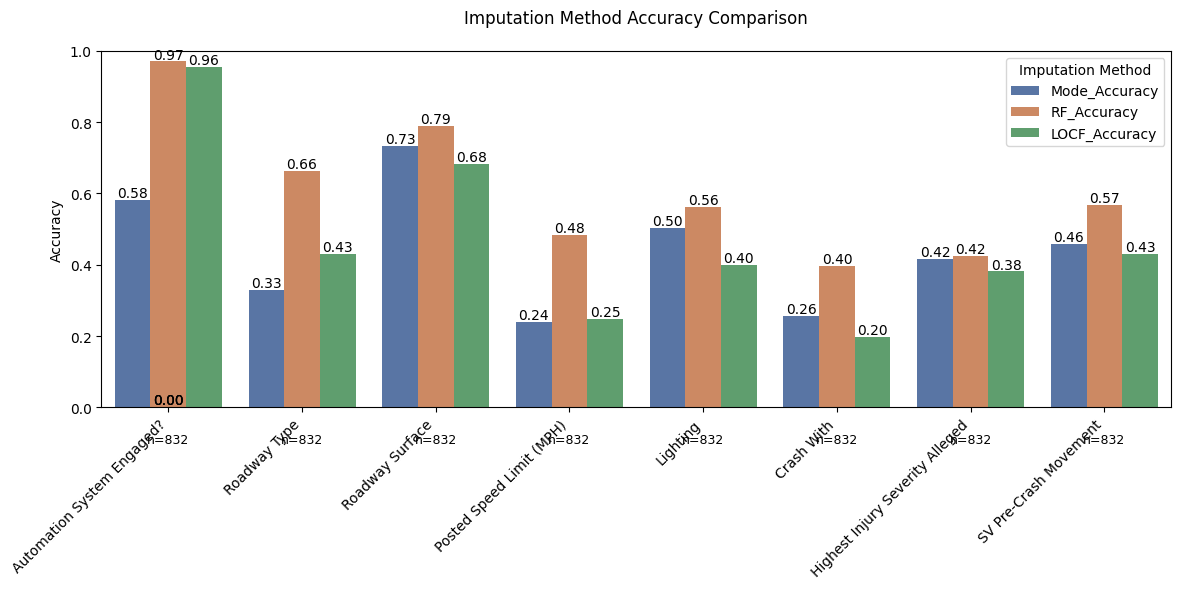

In [66]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_imputation_results(results_df):
    plt.figure(figsize=(12, 6))
    
    # Melt dataframe for seaborn
    plot_df = results_df.melt(
        id_vars=['Column', 'Test_Values_Count'],
        value_vars=['Mode_Accuracy', 'RF_Accuracy', 'LOCF_Accuracy'],
        var_name='Method',
        value_name='Accuracy'
    )
    
    # Create custom palette
    palette = {
        'Mode_Accuracy': '#4c72b0',
        'RF_Accuracy': '#dd8452',
        'LOCF_Accuracy': '#55a868'
    }
    
    # Barplot
    ax = sns.barplot(
        data=plot_df,
        x='Column',
        y='Accuracy',
        hue='Method',
        palette=palette
    )
    
    # Annotate sample size
    for i, col in enumerate(results_df['Column']):
        count = results_df.loc[results_df['Column'] == col, 'Test_Values_Count'].values[0]
        ax.text(i, -0.1, f'n={count}', ha='center', fontsize=9)
    
    plt.title('Imputation Method Accuracy Comparison', pad=20)
    plt.ylabel('Accuracy')
    plt.xlabel('')
    plt.ylim(0, 1)
    plt.xticks(rotation=45, ha='right')
    plt.legend(title='Imputation Method')
    plt.tight_layout()
    
    # Add value labels
    for p in ax.patches:
        ax.annotate(
            f"{p.get_height():.2f}",
            (p.get_x() + p.get_width() / 2., p.get_height()),
            ha='center', va='center',
            xytext=(0, 5),
            textcoords='offset points'
        )
    
    plt.show()

# Usage
plot_imputation_results(results_df)

**Final Imputation - Random**

In [67]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.preprocessing import LabelEncoder

def final_rf_impute(df, columns_to_impute):
    """Final Random Forest imputation for both categorical and numerical columns"""
    df_imputed = df.copy()
    
    for col in columns_to_impute:
        # Skip if no missing values
        if df[col].isna().sum() == 0:
            continue
            
        print(f"Imputing: {col}")
        is_numerical = pd.api.types.is_numeric_dtype(df[col])
        
        # Get complete cases for training
        complete_cases = df.dropna(subset=[col])
        
        # Select feature columns (must have no missing values)
        feature_cols = [c for c in df.columns 
                       if c != col and df[c].notna().all()]
        
        if not feature_cols:
            print(f"  No complete features for {col}, using mode/median")
            if is_numerical:
                df_imputed[col] = df[col].fillna(df[col].median())
            else:
                df_imputed[col] = df[col].fillna(df[col].mode()[0])
            continue
            
        # Prepare features (one-hot encode)
        X = pd.get_dummies(complete_cases[feature_cols], drop_first=True)
        
        # Handle target based on type
        if is_numerical:
            # Numerical imputation
            y = complete_cases[col].values
            model = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
        else:
            # Categorical imputation
            le = LabelEncoder()
            y = le.fit_transform(complete_cases[col].astype(str))
            model = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
        
        # Train model
        model.fit(X, y)
        
        # Predict missing values
        missing_mask = df[col].isna()
        X_missing = pd.get_dummies(df[missing_mask][feature_cols], drop_first=True)
        X_missing = X_missing.reindex(columns=X.columns, fill_value=0)
        
        if not X_missing.empty:
            preds = model.predict(X_missing)
            
            # Post-processing
            if is_numerical:
                df_imputed.loc[missing_mask, col] = preds
            else:
                df_imputed.loc[missing_mask, col] = le.inverse_transform(preds)
    
    return df_imputed

# Define columns to impute (including numerical speed limits)
cols_to_impute = [
    'Automation System Engaged?',
    'Roadway Type',
    'Roadway Surface',
    'Posted Speed Limit (MPH)',  # Will be handled as numerical
    'Lighting',
    'Crash With',
    'Highest Injury Severity Alleged',
    'SV Pre-Crash Movement'
]

# Perform final imputation
final_imputed_data = final_rf_impute(US_data, cols_to_impute)

# 1. Check random samples of imputed values
print("\nSample imputed values:")
for col in cols_to_impute:
    if US_data[col].isna().sum() > 0:
        print(f"\n{col}:")
        print(final_imputed_data.loc[US_data[col].isna(), col].head())

# 2. Validate speed limit imputation
if 'Posted Speed Limit (MPH)' in cols_to_impute:
    print("\nSpeed Limit Stats:")
    print(f"Original median: {US_data['Posted Speed Limit (MPH)'].median()}")
    print(f"Imputed median: {final_imputed_data['Posted Speed Limit (MPH)'].median()}")
    print("Value counts:")
    print(final_imputed_data['Posted Speed Limit (MPH)'].value_counts().head())



Imputing: Automation System Engaged?
Imputing: Roadway Type
Imputing: Roadway Surface
Imputing: Posted Speed Limit (MPH)
Imputing: Lighting
Imputing: Crash With
Imputing: Highest Injury Severity Alleged
Imputing: SV Pre-Crash Movement

Sample imputed values:

Automation System Engaged?:
0    ADAS
1     ADS
2     ADS
4    ADAS
9    ADAS
Name: Automation System Engaged?, dtype: object

Roadway Type:
47     Highway / Freeway
52     Highway / Freeway
122    Highway / Freeway
123    Highway / Freeway
124    Highway / Freeway
Name: Roadway Type, dtype: object

Roadway Surface:
6     Dry
9     Dry
10    Dry
11    Dry
16    Dry
Name: Roadway Surface, dtype: object

Posted Speed Limit (MPH):
9     73.15
11    73.15
14    72.55
16    73.10
17    73.15
Name: Posted Speed Limit (MPH), dtype: float64

Lighting:
6     Daylight
9     Daylight
11    Daylight
17    Daylight
19    Daylight
Name: Lighting, dtype: object

Crash With:
63       Other Fixed Object
65     Other, see Narrative
99       Other F

**Encoding**

In [120]:
def encode_data(df, categorical_cols, datetime_cols, numerical_cols, index_cols=None):
    """
    Encodes categorical and datetime features while preserving numerical features.
    
    Parameters:
        df: Input DataFrame
        categorical_cols: List of categorical column names
        datetime_cols: List of datetime column names
        numerical_cols: List of numerical columns to keep
        index_cols: List of index columns to keep (won't be encoded)
        
    Returns:
        Tuple of (encoded DataFrame, dictionary of label encoders)
    """
    df_encoded = df.copy()
    encoders = {}
    
    # Process datetime columns
    for col in datetime_cols:
        if col in df_encoded.columns:
            if 'date' in col.lower():
                df_encoded[col] = pd.to_datetime(df_encoded[col])
                df_encoded[f'{col}_year'] = df_encoded[col].dt.year
                df_encoded[f'{col}_month'] = df_encoded[col].dt.month
                df_encoded[f'{col}_day'] = df_encoded[col].dt.day
                df_encoded[f'{col}_dayofweek'] = df_encoded[col].dt.dayofweek
            elif 'time' in col.lower():
                df_encoded[col] = pd.to_datetime(df_encoded[col])
                df_encoded[f'{col}_hour'] = df_encoded[col].dt.hour
                df_encoded[f'{col}_minute'] = df_encoded[col].dt.minute
            df_encoded.drop(col, axis=1, inplace=True)
    
    # Update categorical columns with datetime-derived features
    datetime_derived = [col for col in df_encoded.columns 
                       if any(x in col for x in ['_year', '_month', '_day', '_dayofweek', '_hour', '_minute'])]
    categorical_cols = list(set(categorical_cols + datetime_derived))
    
    # Encode categorical columns
    for col in categorical_cols:
        if col in df_encoded.columns and col not in (index_cols or []):
            try:
                le = LabelEncoder()
                df_encoded[col] = le.fit_transform(df_encoded[col].astype(str))
                encoders[col] = le
            except Exception as e:
                print(f"Could not encode column {col}: {str(e)}")
                df_encoded.drop(col, axis=1, inplace=True)
    
    # Normalize numerical columns (excluding index columns)
    numerical_cols = [col for col in numerical_cols 
                     if col in df_encoded.columns and col not in (index_cols or [])]
    if numerical_cols:
        try:
            scaler = MinMaxScaler()
            df_encoded[numerical_cols] = scaler.fit_transform(df_encoded[numerical_cols])
        except Exception as e:
            print(f"Could not normalize numerical columns: {str(e)}")
    
    return df_encoded, encoders



In [131]:
# Define your columns
UK_categorical_cols = [
    'Highest Injury Severity Alleged', 'Roadway Type', 'Lighting', 
    'Weather', 'Roadway Surface', 'City', 'State',
    'Make', 'Model', 'Model Year', 'Automation System Engaged?'
    'Posted Speed Limit (MPH)'
]
US_categorical_cols = [
    'Highest Injury Severity Alleged', 'Roadway Type', 'Lighting', 
    'Weather', 'Roadway Surface', 'City', 'State',
    'Make', 'Model', 'Model Year', 'ADS Equipped?', 'Automation System Engaged?'
    'Posted Speed Limit (MPH)'
]
datetime_cols = ['Incident Date', 'Incident Time (24:00)']
numerical_cols = []
index_cols = ['Report ID', 'Report Version']

# Encode your DataFrame
US_encoded_df, encoders = encode_data(
    df=US_imputing_dataset,
    categorical_cols=US_categorical_cols,
    datetime_cols=datetime_cols,
    numerical_cols=numerical_cols,
    index_cols=index_cols
)

UK_encoded_df, encoders = encode_data(
    df=UK_data,
    categorical_cols=UK_categorical_cols,
    datetime_cols=datetime_cols,
    numerical_cols=numerical_cols,
    index_cols=index_cols
)

**Heatmap**

In [128]:
def plot_heatmap(encoded_df, index_cols=None, figsize=(20, 16), 
                 annot=True, cmap='coolwarm', fmt='.2f'):
    """
    Plots a correlation heatmap from an encoded DataFrame.
    
    Parameters:
        encoded_df: DataFrame with encoded values
        index_cols: List of columns to exclude from heatmap
        figsize: Figure size tuple
        annot: Whether to show correlation values in cells
        cmap: Color map to use
        fmt: String formatting for annotations
    """
    # Determine columns to plot
    plot_cols = [col for col in encoded_df.columns 
                if col not in (index_cols or []) 
                and pd.api.types.is_numeric_dtype(encoded_df[col])]
    
    if not plot_cols:
        raise ValueError("No numeric columns available for correlation calculation")
    
    # Calculate correlation matrix
    corr_matrix = encoded_df[plot_cols].corr()
    
    # Plot heatmap
    plt.figure(figsize=figsize)
    sns.heatmap(corr_matrix, annot=annot, cmap=cmap, center=0, fmt=fmt,
                linewidths=0.5, linecolor='gray', cbar_kws={'shrink': 0.8})
    plt.title('Feature Correlation Heatmap', pad=20, fontsize=16)
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

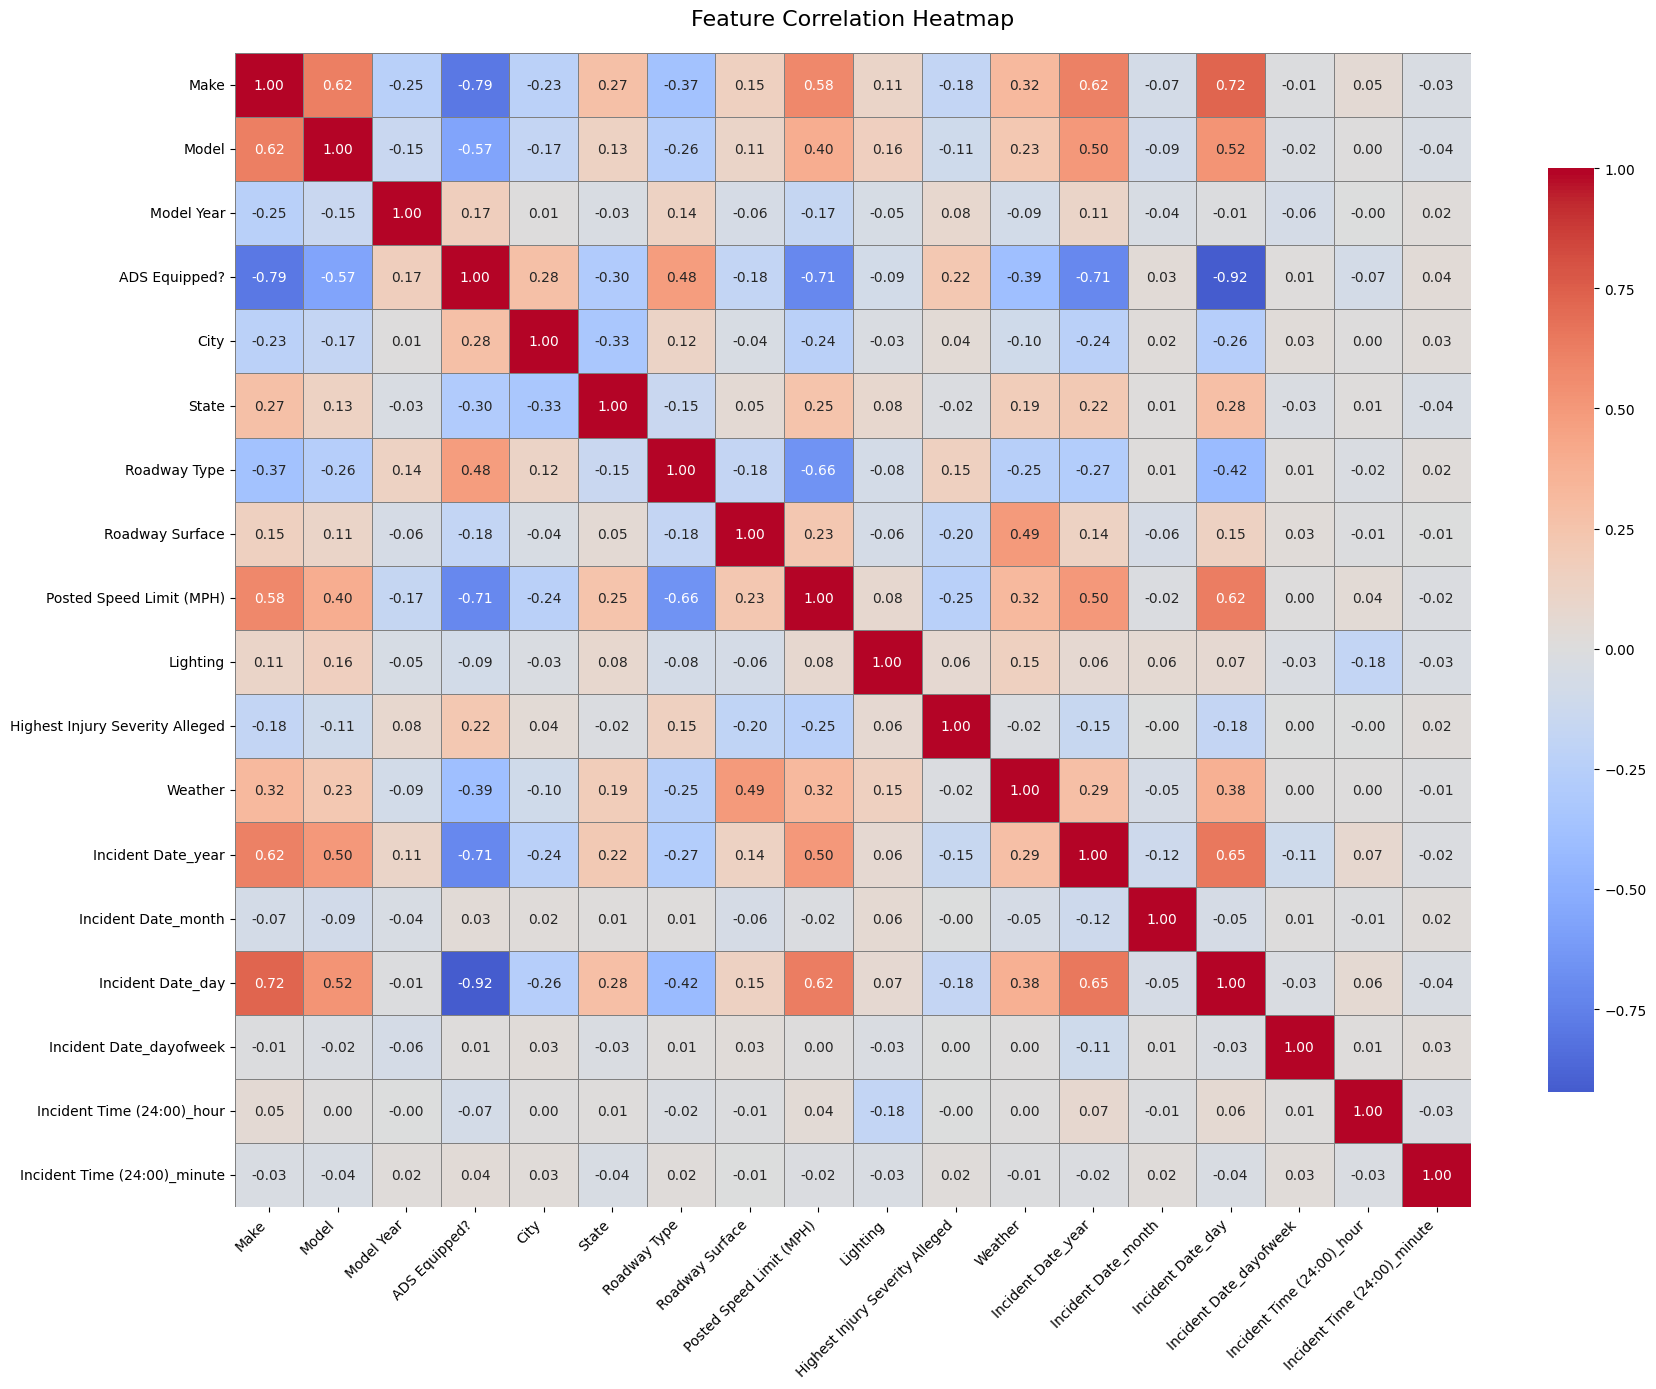

In [129]:
# Plot heatmap from the encoded data
plot_heatmap(
    encoded_df=US_encoded_df,
    index_cols=index_cols,
    figsize=(18, 14),  # Customize size
    annot=True,        # Show correlation values   
)

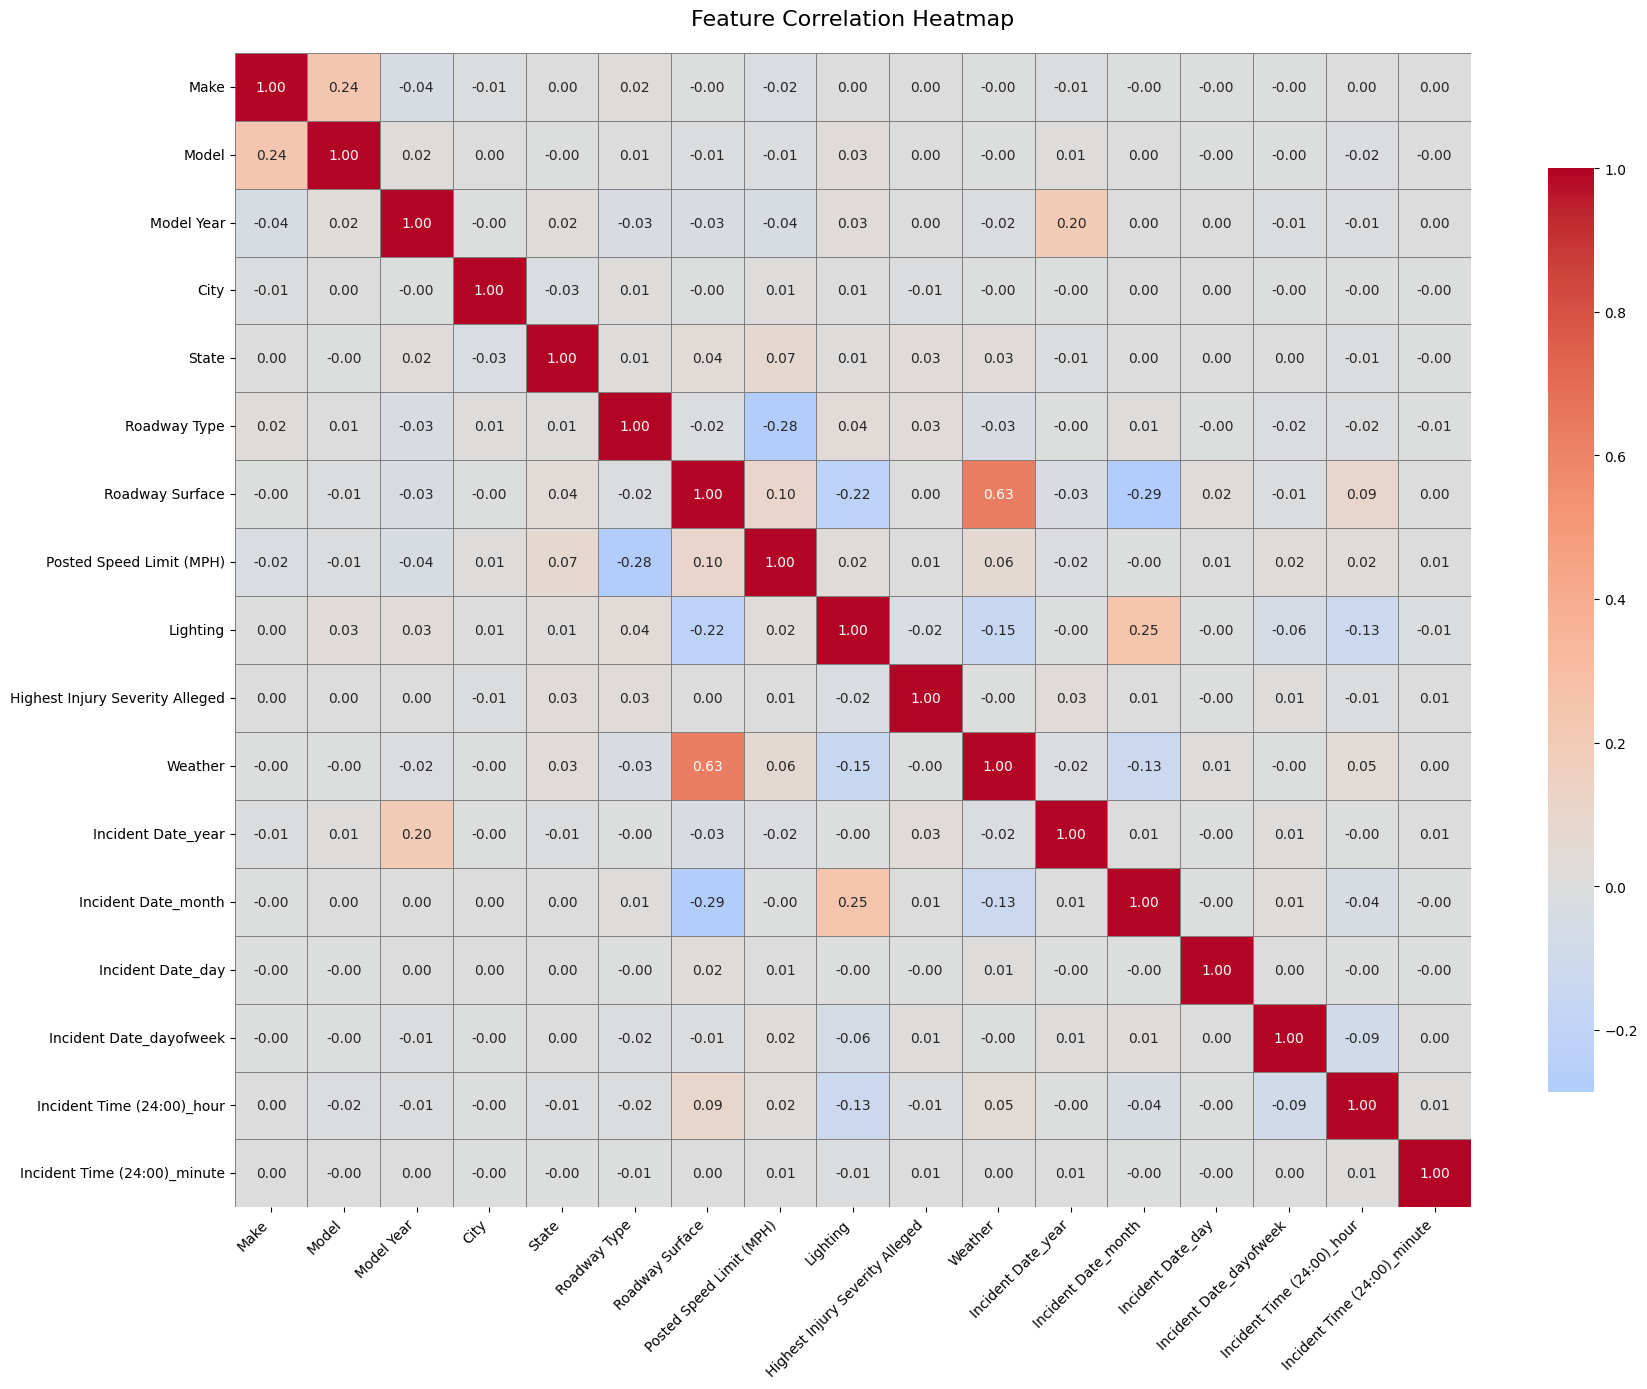

In [132]:
# Plot heatmap from the encoded data
plot_heatmap(
    encoded_df=UK_encoded_df,
    index_cols=index_cols,
    figsize=(18, 14),  # Customize size
    annot=True,        # Show correlation values
)